In [1]:
#These lines are used to mount the drive when using GOOGLE COLAB. Ignore else.
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

In [15]:
#defining transformations for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

trainset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
validset = datasets.MNIST(root='data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=True)

Processing...
Done!


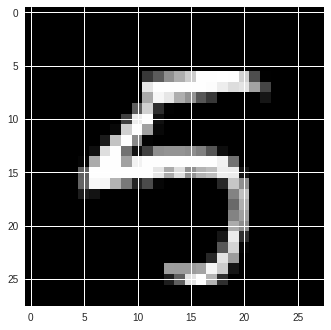

In [4]:
#visulaising the dataset
images, labels = next(iter(trainloader))
images = images.numpy()

image = np.squeeze(images[0])
plt.imshow(image, cmap='gray')

In [6]:
#defining the Discriminator Model

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super().__init__()

        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_size)

        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
    
        x = x.view(-1, 28*28)

        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)

        out = self.fc4(x)

        return out
    

In [7]:
#defining the Generator Model

class Generator(nn.Module):
    
    def __init__(self, input_size, hidden_dim, output_size):
        super().__init__()

        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.fc4 = nn.Linear(hidden_dim*4, output_size)

        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
    
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)

        out = F.tanh(self.fc4(x))

        return out


In [9]:
#hyper parameters for discriminator
input_size = 784
d_hidden_size = 32
d_output_size = 1

#hyper parameter for generator
z_size = 100
g_hidden_size = 32
g_output_size = 784

In [10]:
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

cuda_available = torch.cuda.is_available()
if cuda_available:
    D = D.cuda()
    G = G.cuda()

print('Discriminator:\n', D)
print('\nGenerator:\n', G)

Discriminator:
 Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)

Generator:
 Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3)
)


In [11]:
#defining the real loss
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if cuda_available:
        D_out = D_out.cpu()
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
      
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss
  
def fake_loss(D_out):
    if cuda_available:
        D_out = D_out.cpu()
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

In [0]:
#defining the optimizers
d_optimizer = optim.Adam(D.parameters(), lr=0.002)
g_optimizer = optim.Adam(G.parameters(), lr=0.002)

In [21]:
epochs = 100
sample_size=16
samples = []
losses = {'d_loss':[], 'g_loss':[]}

fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
if cuda_available:
    fixed_z =fixed_z.cuda()

for e in range(epochs):

    for real_images, _ in trainloader:

        if cuda_available:
            real_images = real_images.cuda()

        batch_size = real_images.size(0)

        # train the discriminator with real images
        d_optimizer.zero_grad()
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)

        #train the discriminator with fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()

        if cuda_available:
            z = z.cuda()

        fake_images = G(z)

        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        #train the generator
        g_optimizer.zero_grad()
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()

        if cuda_available:
            z = z.cuda()

        fake_images = G(z)

        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels

        g_loss.backward()
        g_optimizer.step()

    print('Epoch: {}/{} -- D Loss: {:.3f} -- G Loss: {:.3f}'.format(e, epochs, d_loss, g_loss))

    losses['d_loss'].append(d_loss)
    losses['g_loss'].append(g_loss)

    G.eval()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train()

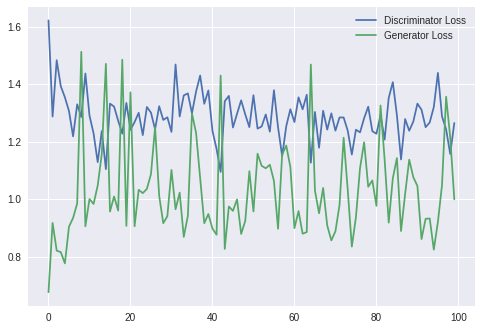

In [0]:
#plotting the generator as well as dicriminator loss
plt.plot(losses['d_loss'], label='Discriminator Loss')
plt.plot(losses['g_loss'], label='Generator Loss')
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


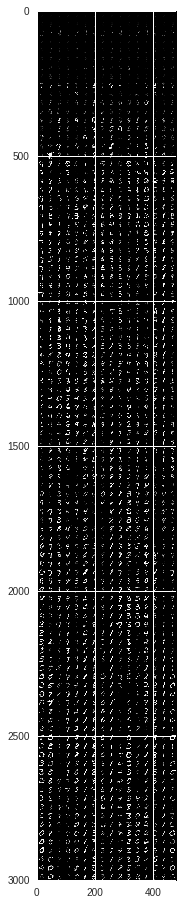

In [0]:
#we have stored some images during training. now we will combine
#all the images and display

sample_numpy = np.array([np.array(x.detach().cpu().numpy()) for x in samples])

sample_images = torch.from_numpy(sample_numpy)
sample_images = sample_images.view(-1, 1, 28, 28)
grid_image = torchvision.utils.make_grid(sample_images, nrow=16)

plt.figure(figsize=(20,16))
plt.imshow(grid_image.permute(1, 2, 0))

As you can see, in the starting the images shown do not represent anything. During training, generator learns to generate images which are close to mnist. In the final part, most of the images shown do look like images from MNIST(not all).

In [0]:
#save the models
torch.save(G.state_dict(), 'drive/My Drive/Colab Notebooks/Deep Learning/Deep Learning Nanodegree/MNIST GAN/checkpointG.pth')
torch.save(D.state_dict(), 'drive/My Drive/Colab Notebooks/Deep Learning/Deep Learning Nanodegree/MNIST GAN/checkpointD.pth')

In [0]:
#loading the saved models
D.load_state_dict(torch.load('drive/My Drive/Colab Notebooks/Deep Learning/Deep Learning Nanodegree/MNIST GAN/checkpointD.pth'))
G.load_state_dict(torch.load('drive/My Drive/Colab Notebooks/Deep Learning/Deep Learning Nanodegree/MNIST GAN/checkpointG.pth'))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


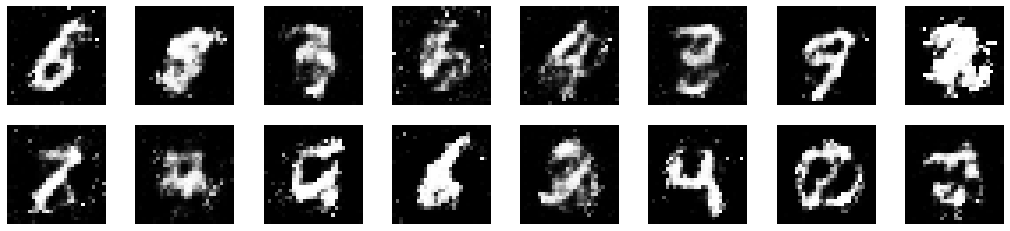

In [45]:
#Generating images and displaying
sample_size = 16

fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
if cuda_available:
  fixed_z =fixed_z.cuda()

images = G(fixed_z)
images = images.view(-1, 1, 28, 28).squeeze()
images_numpy = images.detach().cpu().numpy()

fig = plt.figure(figsize=(18,4))
for i in range(16):
    ax = fig.add_subplot(2,8,i+1, xticks=[], yticks=[])
    plt.imshow(images_numpy[i], cmap='Greys_r')

In [43]:
#testing on validation set, our validation set consists of all real images so our output from
#discriminator should be close to 1, but our output is aroung 0.5 which means the discriminator could not accurately
#distinguish images
accuracy = 0
for images, _ in validloader:
  
    if cuda_available:
      images = images.cuda()
    scores = D(images)
    scores = torch.sigmoid(scores)
    #print(scores)
    scores = scores >= 0.5
    correct = scores.float().sum()
    accuracy += correct

accuracy = accuracy/len(validloader.dataset)
print('Accuracy of discriminator on real images: ', accuracy)

Accuracy of discriminator on real images:  tensor(0.5383, device='cuda:0')
